In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import pandas as pd 

In [2]:
# for folder in os.listdir('images'):
#     for file in os.listdir(f'images/{folder}'):
#         if 'depth' in file:
#             os.remove(f'images/{folder}/{file}')

In [3]:
N_KEYPOINTS = 9

In [4]:
def gaussian_k(x0, y0, sigma, width, height):
        """ Make a square gaussian kernel centered at (x0, y0) with sigma as SD.
        """
        x = np.arange(0, width, 1, float) ## (width,)
        y = np.arange(0, height, 1, float)[:, np.newaxis] ## (height,1)
        return np.exp(-((x-x0)**2 + (y-y0)**2) / (2*sigma**2))

def generate_hm(height, width, points, sigma):
        """ Generate a full Heap Map for every points in an array
        Args:
            height    : The height of Heat Map (the height of target output)
            width     : The width  of Heat Map (the width of target output)
        """
        hm = np.zeros((height, width, len(points)), dtype = np.float32)
        for i in range(len(points)):
            hm[:,:,i] = gaussian_k(points[i][0],
                                   points[i][1],
                                   sigma, width, height)
        return hm
    
def get_y_as_heatmap(keypoints, height, width, sigma):
    keypoints = keypoints.reshape((-1, N_KEYPOINTS, 2))
    return np.array([generate_hm(height, width, image_keypoints, sigma) for image_keypoints in keypoints], dtype=np.float32)

In [5]:
train_dataset_numbers = ['06', '09', '10', '11', '12', '18', '24', '30', '37', '38']
test_dataset_numbers = ['50']

def load_keypoints(dataset_numbers):
    file_start, file_end = 'keypoints/00', '_keypoints2d.txt'
    keypoints = [pd.read_csv(file_start+no+file_end, header=None).loc[:, 1:].values for no in dataset_numbers]
    return np.vstack(keypoints)

keypoints_train, keypoints_test = load_keypoints(train_dataset_numbers), load_keypoints(test_dataset_numbers)
n_test = keypoints_test.shape[0]
keypoints_train.shape, keypoints_test.shape

((2820, 18), (320, 18))

In [6]:
def produce_heatmaps(keypoints, width=128, height=128, sigma=5):
    heatmaps = get_y_as_heatmap(keypoints, height, width, sigma)
    return heatmaps

heatmaps_train, heatmaps_test = produce_heatmaps(keypoints_train), produce_heatmaps(keypoints_test)
heatmaps_train.shape, heatmaps_test.shape

((2820, 128, 128, 9), (320, 128, 128, 9))

In [7]:
from pathlib import Path
root = Path().cwd()/"images"

images = tf.keras.preprocessing.image_dataset_from_directory(
    root,
    image_size=(128, 128),
    shuffle=False
)

images, _ = zip(*images.unbatch())
images = np.array(images)

images.shape

Found 3140 files belonging to 11 classes.


(3140, 128, 128, 3)

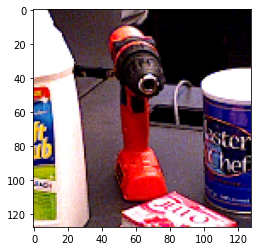

In [8]:
images /= 255.
plt.imshow(images[0])

In [9]:
images_train, images_test = images[:-n_test], images[-n_test:]

images_train.shape, images_test.shape

((2820, 128, 128, 3), (320, 128, 128, 3))

## Visualize image together with heatmap

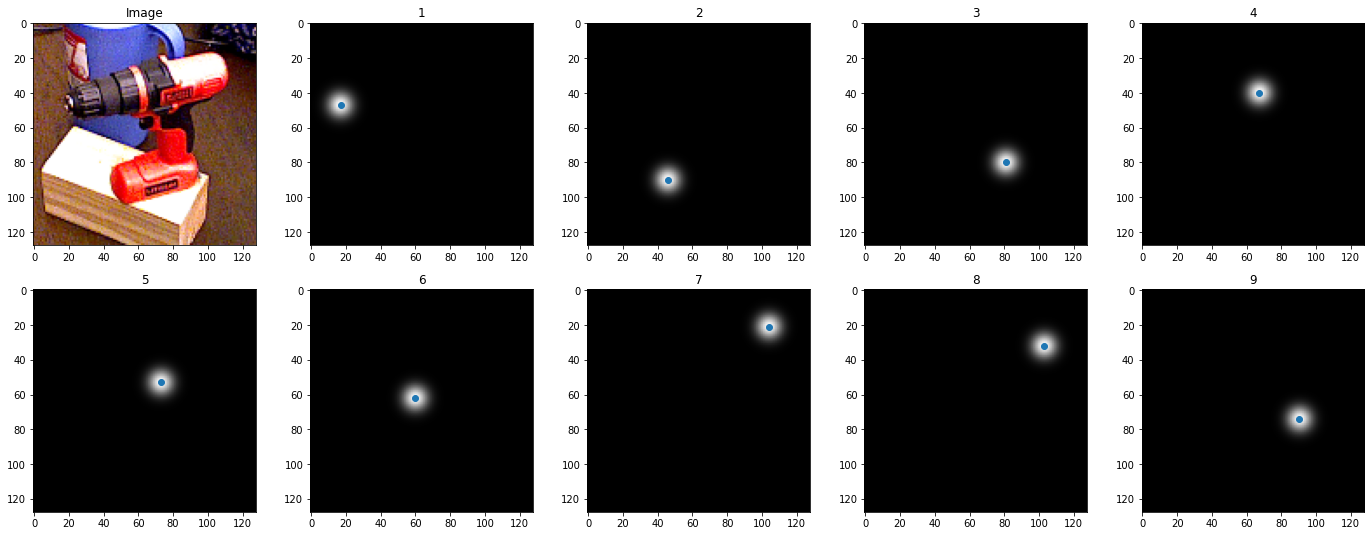

In [10]:
idx = 320

def plot_image_with_keypoints_heatmap(image, heatmap, keypoints=None, pred_keypoints=None, save_path=None):
    keypoint_number = heatmap.shape[2] + 1

    fig = plt.figure(figsize=(24,9))
    ax = fig.add_subplot(2, keypoint_number // 2, 1)
    ax.imshow(image)
    ax.set_title("Image")
    for i in range(heatmaps_train.shape[-1]):
        ax = fig.add_subplot(2, keypoint_number // 2, i + 2)
        ax.imshow(heatmap[:,:,i],cmap="gray")
        ax.set_title(str(i+1))
        if keypoints is not None:
            ax.scatter(keypoints[i*2], keypoints[i*2 + 1])
        if pred_keypoints is not None:
            ax.scatter(pred_keypoints[0][0][i], pred_keypoints[0][1][i])
            
    if save_path is not None:
        plt.savefig(save_path)
        
    plt.show()

plot_image_with_keypoints_heatmap(images_train[idx], heatmaps_train[idx], keypoints_train[idx], save_path='plots/example_true_keypoints.jpg')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


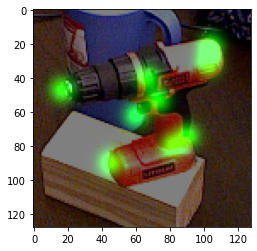

In [11]:
def plot_image_with_heatmaps(image, heatmap, save_path=None):
    image = image.copy()
    image *= 0.5

    for i in range(9):
        image[:, :, 1] = image[:, :, 1] + heatmap[:,:,i]

    plt.imshow(image)
    if save_path is not None:
        plt.savefig(save_path)
    
plot_image_with_heatmaps(images_train[idx], heatmaps_train[idx])

# Model

In [12]:
from stacked_hourglass import create_stacked_hourglass_model

N_HOURGLASSES = 4
N_FILTERS = 128
SMALLEST_SHAPE = 8

In [15]:
img_input = tf.keras.Input(shape=(128, 128, 3))
stacked_hourglass_model = create_stacked_hourglass_model(img_input, 
                                                         N_KEYPOINTS, 
                                                         N_HOURGLASSES,
                                                         N_FILTERS,
                                                         SMALLEST_SHAPE,
                                                         mode='residual')

loss_weights = [1] * N_HOURGLASSES
loss_weights[-1] = 2

stacked_hourglass_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00002), # first 15: 0.0002, later: 0.00002
                                loss=tf.keras.losses.mean_squared_error,
                                loss_weights=loss_weights)

stacked_hourglass_model.load_weights('./model_checkpoints/stacked_hourglass/best')
print('train')
stacked_hourglass_model.evaluate(images_train, heatmaps_train, batch_size=10, verbose=2)
print('test')
stacked_hourglass_model.evaluate(images_test, heatmaps_test, batch_size=10, verbose=2)
None

train
282/282 - 32s - loss: 0.0022 - output_0_loss: 0.0011 - output_1_loss: 3.5712e-04 - output_2_loss: 2.6638e-04 - output_3_loss: 2.2753e-04 - 32s/epoch - 113ms/step
test
32/32 - 3s - loss: 0.0212 - output_0_loss: 0.0046 - output_1_loss: 0.0042 - output_2_loss: 0.0042 - output_3_loss: 0.0041 - 3s/epoch - 100ms/step


# Training

In [14]:
cp_callback_best = tf.keras.callbacks.ModelCheckpoint(filepath='./model_checkpoints/stacked_hourglass/best', save_weights_only=True, save_best_only=True, verbose=1)
cp_callback_last = tf.keras.callbacks.ModelCheckpoint(filepath='./model_checkpoints/stacked_hourglass/last', save_weights_only=True, save_best_only=False, verbose=1)
cp_callback_logger = tf.keras.callbacks.CSVLogger(filename='./model_checkpoints/stacked_hourglass/log.csv', separator=',', append=True)

sh_model_history = stacked_hourglass_model.fit(images_train, heatmaps_train, batch_size=10, epochs=25, validation_data=(images_test, heatmaps_test), callbacks=[cp_callback_best, cp_callback_last, cp_callback_logger])

Epoch 1/25
282/282 [==============================] - ETA: 0s - loss: 0.0049 - output_0_loss: 0.0033 - output_1_loss: 7.5460e-04 - output_2_loss: 3.7183e-04 - output_3_loss: 2.6536e-04
Epoch 1: val_loss improved from inf to 0.02144, saving model to ./model_checkpoints/stacked_hourglass\best

Epoch 1: saving model to ./model_checkpoints/stacked_hourglass\last
282/282 [==============================] - 96s 301ms/step - loss: 0.0049 - output_0_loss: 0.0033 - output_1_loss: 7.5460e-04 - output_2_loss: 3.7183e-04 - output_3_loss: 2.6536e-04 - val_loss: 0.0214 - val_output_0_loss: 0.0046 - val_output_1_loss: 0.0044 - val_output_2_loss: 0.0043 - val_output_3_loss: 0.0041
Epoch 2/25
282/282 [==============================] - ETA: 0s - loss: 0.0045 - output_0_loss: 0.0030 - output_1_loss: 6.3819e-04 - output_2_loss: 3.4372e-04 - output_3_loss: 2.5003e-04
Epoch 2: val_loss did not improve from 0.02144

Epoch 2: saving model to ./model_checkpoints/stacked_hourglass\last
282/282 [=================

In [16]:
sh_model_history = pd.read_csv('./model_checkpoints/stacked_hourglass/log.csv')

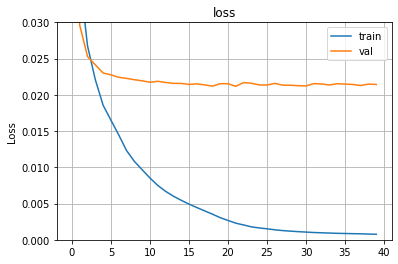

In [17]:
def plot_stats(history, output='loss', save_path=None, ymax=0.03):
    plt.plot(history[output])
    plt.plot(history[f'val_{output}'])
    plt.title('Loss')
    plt.ylabel('Loss')
    ax = plt.gca()
    ax.set_ylim([0.0, ymax])
    plt.legend(['train', 'val'])
    plt.title(output)
    plt.grid()
    
    if save_path is not None:
        plt.savefig(save_path)
        
    plt.show()
    
plot_stats(sh_model_history, save_path='./plots/stacked_hourglass_training/loss.jpg')

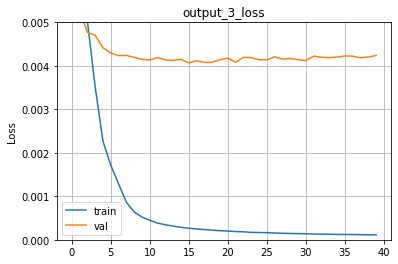

In [18]:
plot_stats(sh_model_history, 'output_3_loss', save_path='./plots/stacked_hourglass_training/output_3_loss.jpg', ymax=0.005)

# Evaluation

In [20]:
def retrieve_keypoints(heatmaps):
    tmp = heatmaps.reshape((heatmaps.shape[0], -1, N_KEYPOINTS))
    tmp = np.argmax(tmp, axis=1)
    tmp = tmp.reshape((tmp.shape[0], 1, tmp.shape[1]))
    return np.hstack([tmp % heatmaps.shape[2], tmp // heatmaps.shape[2]])

def predict_in_batches(model, images, batch_size):
    pred = []
    for i in range(0, images.shape[0], batch_size):
        batch = images[i:i+batch_size]
        pred.append(model.predict(batch)[-1])
    return np.vstack(pred)

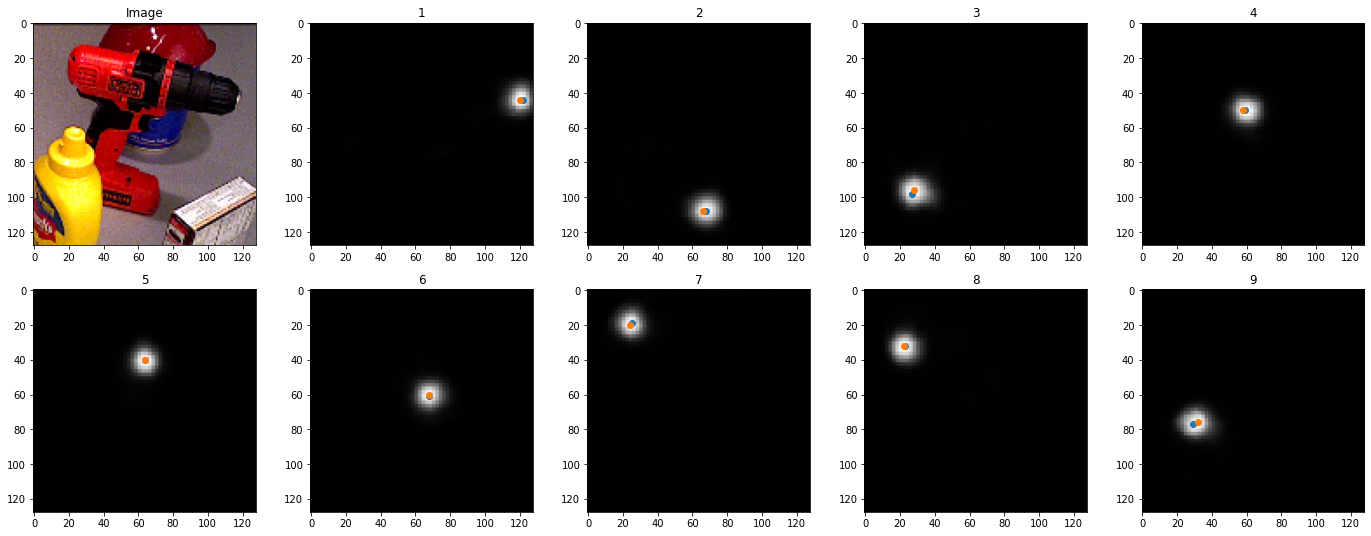

In [21]:
idx = 1500

image = images_train[idx]
pred_heatmaps = stacked_hourglass_model.predict(np.array([image]))[-1]

plot_image_with_keypoints_heatmap(image, pred_heatmaps[0], keypoints_train[idx], retrieve_keypoints(pred_heatmaps), save_path='plots/example_pred_keypoints_train.jpg')

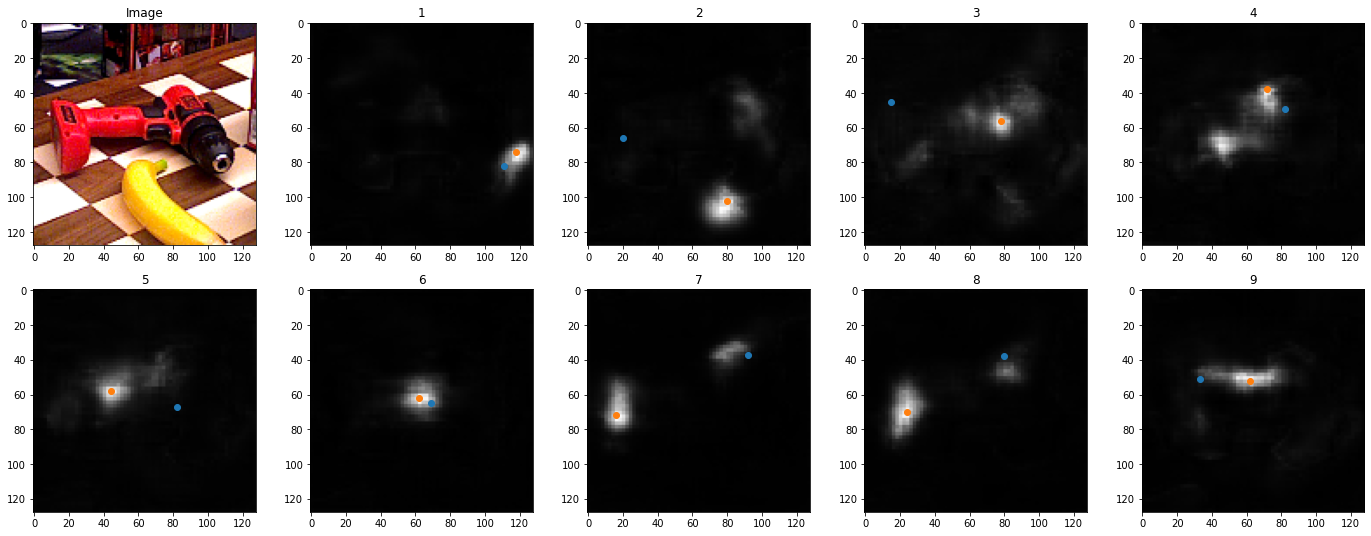

In [22]:
idx = 0

image = images_test[idx]
pred_heatmaps = stacked_hourglass_model.predict(np.array([image]))[-1]

plot_image_with_keypoints_heatmap(image, pred_heatmaps[0], keypoints_test[idx], retrieve_keypoints(pred_heatmaps), save_path='plots/example_pred_keypoints_1.jpg')

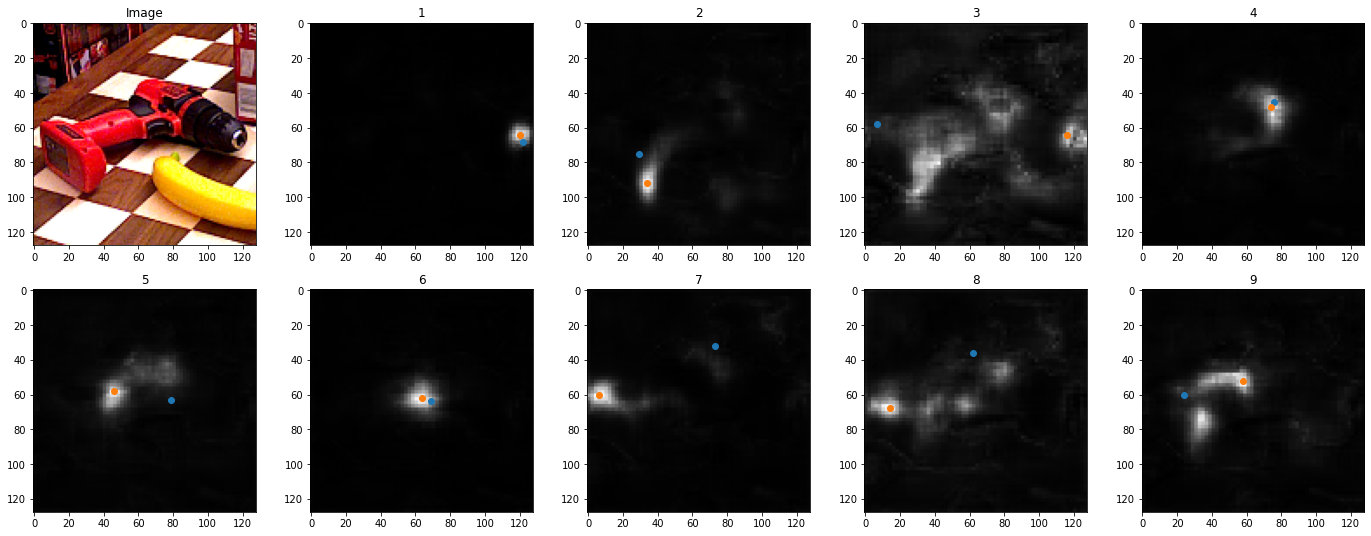

In [23]:
idx = 100

image = images_test[idx]
pred_heatmaps = stacked_hourglass_model.predict(np.array([image]))[-1]

plot_image_with_keypoints_heatmap(image, pred_heatmaps[0], keypoints_test[idx], retrieve_keypoints(pred_heatmaps), save_path='plots/example_pred_keypoints_2.jpg')

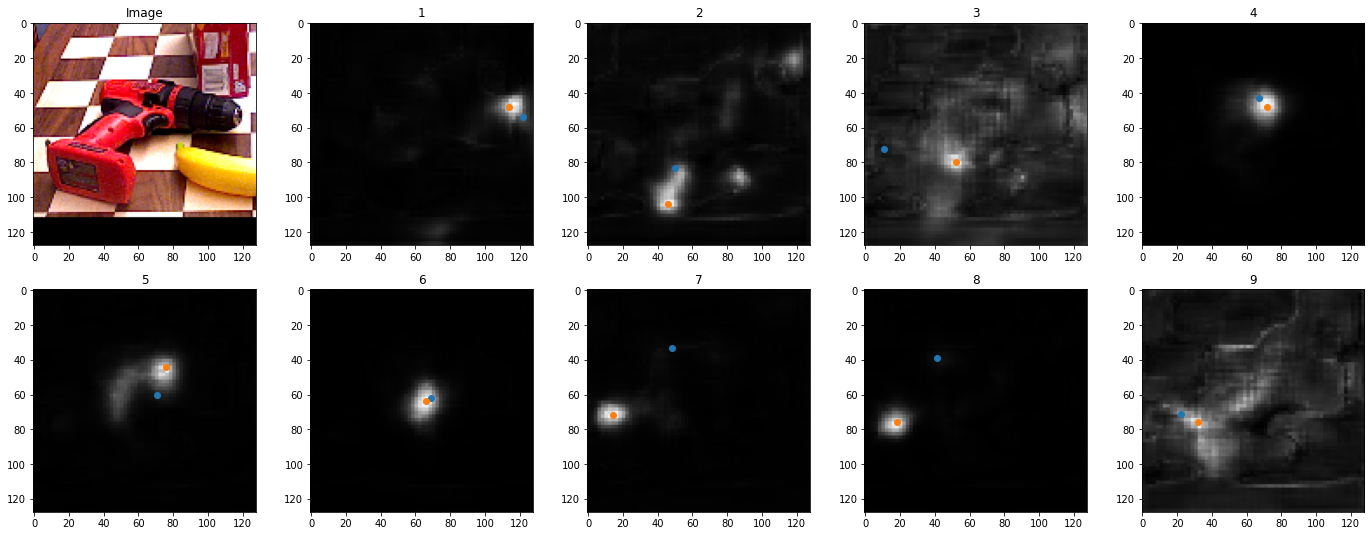

In [24]:
idx = 200

image = images_test[idx]
pred_heatmaps = stacked_hourglass_model.predict(np.array([image]))[-1]

plot_image_with_keypoints_heatmap(image, pred_heatmaps[0], keypoints_test[idx], retrieve_keypoints(pred_heatmaps), save_path='plots/example_pred_keypoints_3.jpg')

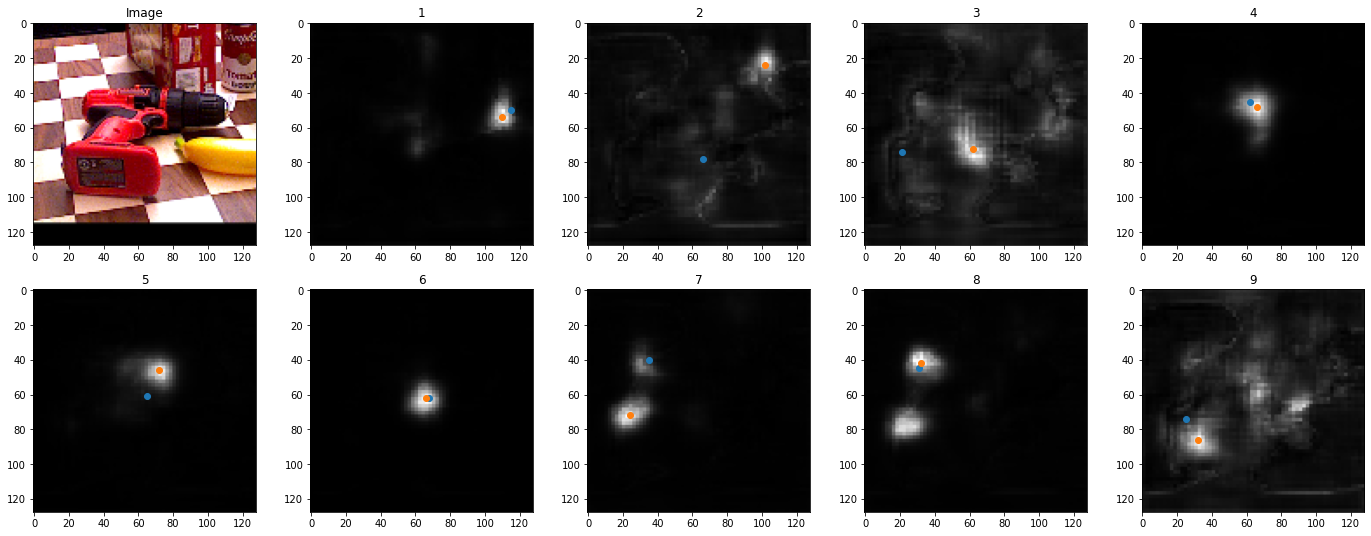

In [25]:
idx = 300

image = images_test[idx]
pred_heatmaps = stacked_hourglass_model.predict(np.array([image]))[-1]

plot_image_with_keypoints_heatmap(image, pred_heatmaps[0], keypoints_test[idx], retrieve_keypoints(pred_heatmaps), save_path='plots/example_pred_keypoints_4.jpg')

# Retrieving keypoints from heatmaps

In [26]:
pred_keypoints_train = retrieve_keypoints(predict_in_batches(stacked_hourglass_model, images_train, 4))
pred_keypoints_test = retrieve_keypoints(predict_in_batches(stacked_hourglass_model, images_test, 4))

pred_keypoints_train.shape, pred_keypoints_test.shape

((2820, 2, 9), (320, 2, 9))

In [27]:
print(keypoints_train[10])
print(np.reshape(pred_keypoints_train[10], (-1, 18), order='F'))

[ 70  43  58 110  51  94  51  44  70  42  64  60  50  16  51  28  59  76]
[[ 72  42  58 110  50  94  50  44  70  40  64  60  50  14  50  26  58  76]]


In [28]:
print(keypoints_test[10])
print(np.reshape(pred_keypoints_test[10], (-1, 18), order='F'))

[111  83  21  64  15  44  82  50  82  67  69  65  92  38  79  39  33  51]
[[118  74  80 102  78  56  44  70  44  58  62  62  16  72  24  66  58  50]]


# Pred vs ground truth - MSE

In [29]:
from sklearn.metrics import mean_squared_error

def calculate_mse(true_values, pred_values):
    return mean_squared_error(true_values, pred_values)

In [30]:
mse = calculate_mse(keypoints_test, np.reshape(pred_keypoints_test, (-1, 18), order='F'))
mse

632.8819444444445

In [31]:
mse = calculate_mse(keypoints_train, np.reshape(pred_keypoints_train, (-1, 18), order='F'))
mse

1.4679866036249014

In [33]:
mean_squared_error(np.full((300, 18), 0), np.full((300, 18), 25))

625.0